In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import joblib.numpy_pickle as joblib
import autoencoder_functions
import features_single
import time
import torch
import seperate_spec_and_features
import create_padded_spectograms
import normalize_padded_spectograms


#### start with the shank3 model
# load shank3 data
usvs_shank3 = joblib.load('shank3USVs_many_properties.jl')
#seperate all features
spec, emitter, distance_to_nearest_non_emitter, duration, start_time_in_recording, end_time_in_recording, intensities, intensity, location, main_freq, recording_path= seperate_spec_and_features.separate_spec_and_features(usvs_shank3)
spec_shank3 = spec
emitter_shank3 = emitter
#choose a number of spectrograms to time the model and get these indices
n_to_time = 1000
indices_to_time = np.random.choice(len(spec_shank3),n_to_time, replace = False)
#initialize model
path_to_model = 'final_models/shank3_8_v0'
parameters = joblib.load(path_to_model + '/parameters.pkl')
latent_space_size = parameters['latent_space_size']
slope_leaky = parameters['slope_leaky']
learning_rate = parameters['learning_rate']
precision_model = parameters['precision_model']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = autoencoder_functions.VAE_KL_leaky(z_dim = latent_space_size, device_name='cuda',slope=slope_leaky,lr = learning_rate, model_precision =precision_model)
model = model.to(device)

#load the model
model_file_name = path_to_model + '/model.pt'
model.load_state_dict(torch.load(model_file_name))

#variables
padding_length = 160
#normalize according to our training
if parameters['max_value_per_spec'] == 'true':
    max_value_per_spec = True




c:\Users\ruben\Documents\Internship\Git repository\VAELiveScope\autoencoder_functions.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() ###
C:\Users\ruben\AppData\Local\Temp\ipykernel_23512\2893307005.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

In [2]:
# The 'shape' argument should be a tuple (rows, columns)
latent = cp.zeros((n_to_time, latent_space_size)) # or appropriate dtype
times = []
#time the model
for i in range(len(indices_to_time)):
    spec_to_test = spec_shank3[indices_to_time[i]]
    start_time = time.time()
    spec_to_test_cp = cp.asarray(spec_to_test)
    spec_to_test_padded = create_padded_spectograms.pad_spectogram_cupy(spec_to_test_cp, padding_length)
    spec_to_test_normalized = normalize_padded_spectograms.normalize_spec_cupy(spec_to_test_padded, max_value_per_spec)
    spec_to_test_np = cp.expand_dims(spec_to_test_normalized, axis=0)
    spec_to_test_torch = torch.as_tensor(spec_to_test_np, device=model.device).float()
    spec_to_test_train_loader = torch.utils.data.DataLoader(spec_to_test_torch, batch_size=1, shuffle=False)
    latent_vector = model.get_latent(spec_to_test_train_loader)
    latent_vector = cp.asarray(latent_vector)
    latent[i] = latent_vector
    torch.cuda.synchronize()
    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second: {:.2f}'.format(n_to_time/total_time))
print(latent[500])


Total time for processing 1000 spectrograms: 2.7155 seconds
Average time per spectrogram: 0.0027 seconds
Average spectrograms processed per second: 368.25
[ 1.08400679  1.04017484  0.28265911  0.01001703 -0.00680307  0.0373476
  0.0180294   0.98507178]


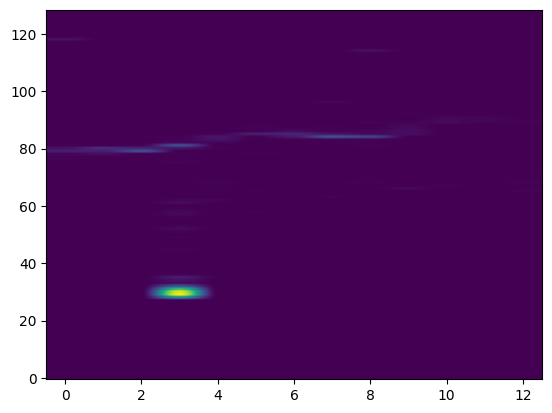

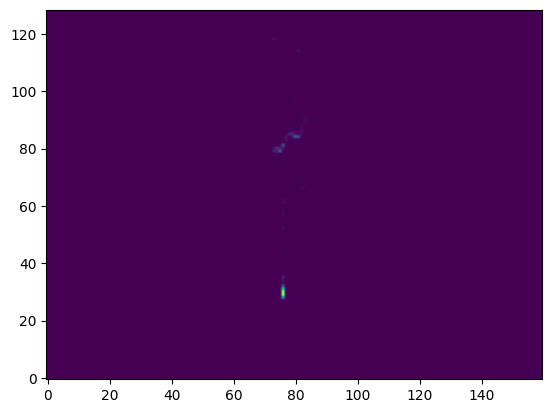

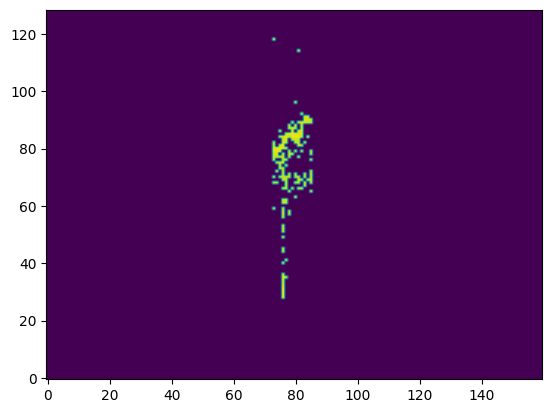

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spec_to_test, aspect='auto', origin='lower')
plt.show()
plt.figure()
plt.imshow(spec_to_test_padded.get(), aspect='auto', origin='lower')
plt.show()
plt.figure()
plt.imshow(spec_to_test_normalized.get(), aspect='auto', origin='lower')
plt.show()

In [4]:
#time the quantitative features
features = []
times =  []
for i in range(len(indices_to_time)):
    spec_to_test = spec_shank3[indices_to_time[i]]
    start_time = time.time()
    spec_to_test = cp.asarray(spec_to_test)
    features_vector = features_single.get_usv_features(spec_to_test)
    cp.cuda.runtime.deviceSynchronize()
    end_time = time.time()
    total_time = end_time - start_time
    features.append(features_vector)
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms for features: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram for features: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second for features: {:.2f}'.format(n_to_time/total_time))
print(features[500])

Total time for processing 1000 spectrograms for features: 9.8983 seconds
Average time per spectrogram for features: 0.0099 seconds
Average spectrograms processed per second for features: 101.03
[[ 2.04800000e-02]
 [ 5.93884582e+04]
 [ 5.81395349e+04]
 [ 6.27906977e+04]
 [ 4.65116279e+03]
 [ 6.27906977e+04]
 [ 5.81395349e+04]
 [-2.24798202e+02]
 [ 2.26664244e-02]
 [ 1.25000000e+00]
 [ 3.64797082e+02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [5]:
#time the quantitative features
features = []
times = []
for i in range(len(indices_to_time)):
    spec_to_test = spec_shank3[indices_to_time[i]]
    start_time = time.time()
    spec_to_test = cp.asarray(spec_to_test)
    features_vector = features_single.get_usv_features_without_integers(spec_to_test)
    cp.cuda.runtime.deviceSynchronize()
    end_time = time.time()
    total_time = end_time - start_time
    features.append(features_vector)
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms for features: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram for features: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second for features: {:.2f}'.format(n_to_time/total_time))
print(features[500])

Total time for processing 1000 spectrograms for features: 3.3496 seconds
Average time per spectrogram for features: 0.0033 seconds
Average spectrograms processed per second for features: 298.54
[[ 2.04800000e-02]
 [ 5.93884582e+04]
 [ 5.81395349e+04]
 [ 6.27906977e+04]
 [ 4.65116279e+03]
 [ 6.27906977e+04]
 [ 5.81395349e+04]
 [-2.24798202e+02]
 [ 2.26664244e-02]
 [ 1.25000000e+00]
 [ 3.64797082e+02]]


In [6]:
# load pups data
usvs_pups = joblib.load('emitter_and_specs.jl')
#seperate all features
spec, emitter = seperate_spec_and_features.seperate_spec_and_emitter_pups(usvs_pups)
spec_pups = spec
emitter_pups = emitter
#choose a number of spectrograms to time the model and get these indices
n_to_time = 1000
indices_to_time = np.random.choice(len(spec_pups),n_to_time, replace = False)
#initialize model
path_to_model = 'final_models/pups_8_v0'
parameters = joblib.load(path_to_model + '/parameters.pkl')
latent_space_size = parameters['latent_space_size']
slope_leaky = parameters['slope_leaky']
learning_rate = parameters['learning_rate']
precision_model = parameters['precision_model']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = autoencoder_functions.VAE_KL_leaky(z_dim = latent_space_size, device_name='cuda',slope=slope_leaky,lr = learning_rate, model_precision =precision_model)
model = model.to(device)

#load the model
model_file_name = path_to_model + '/model.pt'
model.load_state_dict(torch.load(model_file_name))

#variables
padding_length = 160
#normalize according to our training
if parameters['max_value_per_spec'] == 'true':
    max_value_per_spec = True




c:\Users\ruben\Documents\Internship\Git repository\VAELiveScope\autoencoder_functions.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() ###
C:\Users\ruben\AppData\Local\Temp\ipykernel_23512\4024134917.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

In [7]:
# The 'shape' argument should be a tuple (rows, columns)
latent = cp.zeros((n_to_time, latent_space_size)) # or appropriate dtype
times = []
#time the model
for i in range(len(indices_to_time)):
    spec_to_test = spec_pups[indices_to_time[i]]
    start_time = time.time()
    spec_to_test_cp = cp.asarray(spec_to_test)
    spec_to_test_padded = create_padded_spectograms.pad_spectogram_cupy(spec_to_test_cp, padding_length)
    spec_to_test_normalized = normalize_padded_spectograms.normalize_spec_cupy(spec_to_test_padded, max_value_per_spec)
    spec_to_test_np = cp.expand_dims(spec_to_test_normalized, axis=0)
    spec_to_test_torch = torch.as_tensor(spec_to_test_np, device=model.device).float()
    spec_to_test_train_loader = torch.utils.data.DataLoader(spec_to_test_torch, batch_size=1, shuffle=False)
    latent_vector = model.get_latent(spec_to_test_train_loader)
    latent_vector = cp.asarray(latent_vector)
    latent[i] = latent_vector
    torch.cuda.synchronize()
    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second: {:.2f}'.format(n_to_time/total_time))
print(latent[500])


Total time for processing 1000 spectrograms: 2.3590 seconds
Average time per spectrogram: 0.0024 seconds
Average spectrograms processed per second: 423.91
[ 0.01674106 -0.01619518 -0.72682428  0.01277144  0.8390187   0.12177441
 -0.59362209  0.10573418]


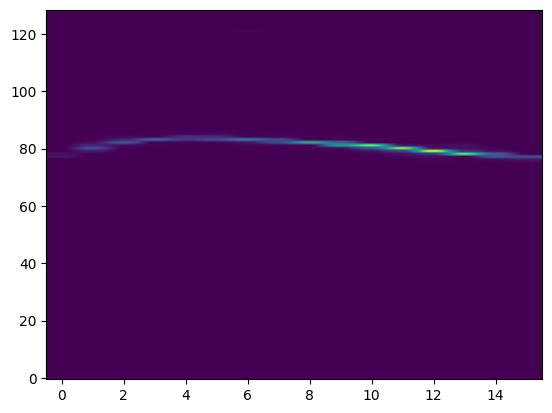

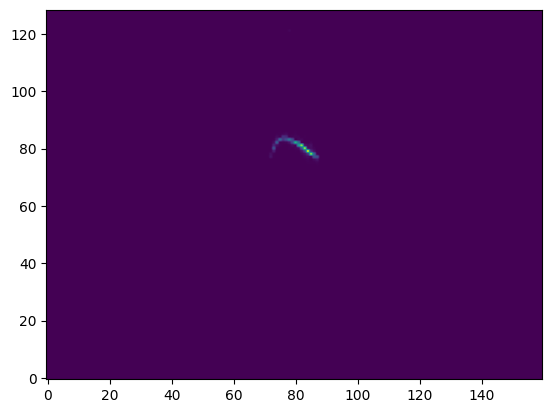

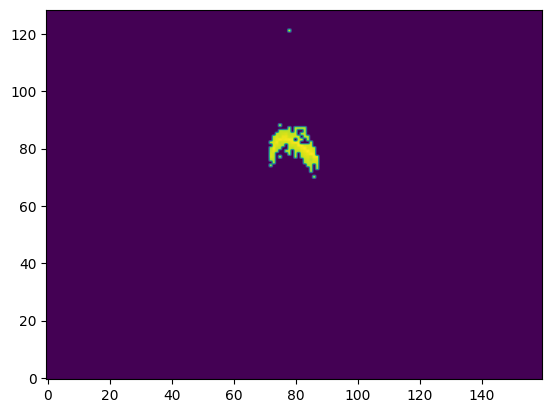

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spec_to_test, aspect='auto', origin='lower')
plt.show()
plt.figure()
plt.imshow(spec_to_test_padded.get(), aspect='auto', origin='lower')
plt.show()
plt.figure()
plt.imshow(spec_to_test_normalized.get(), aspect='auto', origin='lower')
plt.show()

In [9]:
#time the quantitative features
features = []
times =  []
for i in range(len(indices_to_time)):
    spec_to_test = spec_pups[indices_to_time[i]]
    start_time = time.time()
    spec_to_test = cp.asarray(spec_to_test)
    features_vector = features_single.get_usv_features(spec_to_test)
    cp.cuda.runtime.deviceSynchronize()
    end_time = time.time()
    total_time = end_time - start_time
    features.append(features_vector)
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms for features: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram for features: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second for features: {:.2f}'.format(n_to_time/total_time))
print(features[500])

Total time for processing 1000 spectrograms for features: 9.8734 seconds
Average time per spectrogram for features: 0.0099 seconds
Average spectrograms processed per second for features: 101.28
[[ 1.02400000e-02]
 [ 5.46080965e+04]
 [ 4.88372093e+04]
 [ 5.89147287e+04]
 [ 1.00775194e+04]
 [ 5.89147287e+04]
 [ 4.88372093e+04]
 [-1.17571059e+03]
 [ 5.64307376e-02]
 [ 4.28289566e-01]
 [ 1.25968992e+03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [10]:
#time the quantitative features
features = []
times = []
for i in range(len(indices_to_time)):
    spec_to_test = spec_shank3[indices_to_time[i]]
    start_time = time.time()
    spec_to_test = cp.asarray(spec_to_test)
    features_vector = features_single.get_usv_features_without_integers(spec_to_test)
    cp.cuda.runtime.deviceSynchronize()
    end_time = time.time()
    total_time = end_time - start_time
    features.append(features_vector)
    times.append(total_time)
total_time = sum(times)
print('Total time for processing {} spectrograms for features: {:.4f} seconds'.format(n_to_time, total_time))
print('Average time per spectrogram for features: {:.4f} seconds'.format(total_time/n_to_time))
print('Average spectrograms processed per second for features: {:.2f}'.format(n_to_time/total_time))
print(features[500])

Total time for processing 1000 spectrograms for features: 3.2991 seconds
Average time per spectrogram for features: 0.0033 seconds
Average spectrograms processed per second for features: 303.12
[[2.50311111e-02]
 [5.95137421e+04]
 [5.73643411e+04]
 [6.20155039e+04]
 [4.65116279e+03]
 [5.73643411e+04]
 [6.12403101e+04]
 [1.50136348e+02]
 [2.85729509e-02]
 [1.61107280e+00]
 [5.53709856e+02]]
